In [46]:
# Import modules

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
import optuna
from dask.distributed import Client, wait

In [47]:
optimization_time_in_seconds = -time.time()

In [48]:
def study_wrapper(study, n_trials):
    # Load and prepare data

    df = pd.read_csv("/app/story/houses_to_rent_v2.csv") # loading data from volume

    df['floor'] = df['floor'].replace('-',0)
    df['floor'] = df['floor'].astype('int64')

    num_var = []
    for i in df.select_dtypes(include=['int64']):
        num_var.append(i)
        
    cat_var = []
    for i in df.select_dtypes(include=['object']):
        cat_var.append(i)

    df = df.rename(columns={'hoa (R$)':'hoa','rent amount (R$)':'rent_amount','property tax (R$)':'property_tax','fire insurance (R$)':'fire_insurance','total (R$)':'target','parking spaces':'parking_spaces'})

    dummies_cols = ['city', 'furniture', 'animal']
    df= pd.get_dummies(df, columns = dummies_cols, drop_first=True)
    df.drop(['hoa', 'rent_amount', 'property_tax', 'fire_insurance'], axis=1, inplace=True)

    # Split data to train and test sets

    df=df.copy()

    def preprocessing_(df):
        df = df.sample(frac=1.0, random_state=0).reset_index(drop=True)
        X = df.drop('target', axis=1)
        y = df.target
        
        X = pd.DataFrame(X, index=X.index, columns=X.columns)
        
        return X,y

    X, y = preprocessing_(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Defining objective function

    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 5, 40)
        min_samples_split = trial.suggest_int('min_samples_split', 4, 10)
        
        random_forest_regressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
        random_forest_regressor.fit(X_train, y_train)
        
        return np.sqrt(mean_squared_error(y_test, random_forest_regressor.predict(X_test)))
    
    study.optimize(objective, n_trials=n_trials)


In [49]:
n_workers = 10 # broj worker nodova
n_trials = 1000 # broj pokusaja za pronalazenje najboljih parametara

In [50]:
# Split trials to nodes

if n_trials <= n_workers:
    trials_per_node = [1 for i in range(n_trials)]
else:
    whole_trials=n_trials // n_workers
    partional_trials=n_trials % n_workers
    trials_per_node = [whole_trials + (1 if i < partional_trials else 0) for i in range(0, n_workers)]

In [51]:
client = Client("tcp://<server_ip>:<port>")

c:\Users\ljmatovic\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:1617: VersionMismatchWarning: Mismatched versions found

+---------+----------------+-----------------+-----------------+
| Package | Client         | Scheduler       | Workers         |
+---------+----------------+-----------------+-----------------+
| lz4     | None           | 4.3.3           | 4.3.3           |
| python  | 3.10.0.final.0 | 3.10.12.final.0 | 3.10.12.final.0 |
| toolz   | 0.12.1         | 0.12.0          | 0.12.0          |
+---------+----------------+-----------------+-----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


2024-08-10 18:44:50,146 - distributed.batched - INFO - Batched Comm Closed <TCP (closed) Client->Scheduler local=tcp://192.168.0.58:57014 remote=tcp://mn01-fin.bioirc.ac.rs:30100>
Traceback (most recent call last):
  File "c:\Users\ljmatovic\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\batched.py", line 115, in _background_send
    nbytes = yield coro
  File "C:\Users\ljmatovic\AppData\Roaming\Python\Python310\site-packages\tornado\gen.py", line 766, in run
    value = future.result()
  File "c:\Users\ljmatovic\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\comm\tcp.py", line 262, in write
    raise CommClosedError()
distributed.comm.core.CommClosedError


In [52]:
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.dask.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(study_name="RandomForestRegressor", direction='minimize', storage=dask_storage)

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_30580\3840632913.py:2: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.dask.DaskStorage(storage=backend_storage, client=client)


In [53]:
futures = []
print(trials_per_node)
start=0
for i in trials_per_node:
    iter_range = (start + 1, start+i)
    start+=i
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study_wrapper, study, n_trials=i, pure=False)
            ],
        }
    )
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    try:
        _ = wait(partition["futures"])
    except:
        print(f"FAILED: Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Testing hyperparameter combinations 1..100
Testing hyperparameter combinations 101..200
Testing hyperparameter combinations 201..300
Testing hyperparameter combinations 301..400
Testing hyperparameter combinations 401..500
Testing hyperparameter combinations 501..600
Testing hyperparameter combinations 601..700
Testing hyperparameter combinations 701..800
Testing hyperparameter combinations 801..900
Testing hyperparameter combinations 901..1000


In [54]:
optimization_time_in_seconds += time.time()

In [55]:
print("Best params:", study.best_params)
print("Best value:", study.best_value)
minutes = int(optimization_time_in_seconds) // 60
seconds = int(optimization_time_in_seconds)
seconds = seconds % 60 + (optimization_time_in_seconds - int(optimization_time_in_seconds))    
print("Optimization time: {} m {} s".format(minutes, seconds))

Best params: {'n_estimators': 165, 'max_depth': 6, 'min_samples_split': 10}
Best value: 4220.388491027582
Optimization time: 7 m 55.71546959877014 s


In [56]:
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_30580\978520437.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


<Axes: title={'center': 'Brazil Rent RandomForestRegressor Optimization history'}, xlabel='Trial', ylabel='Objective Value'>

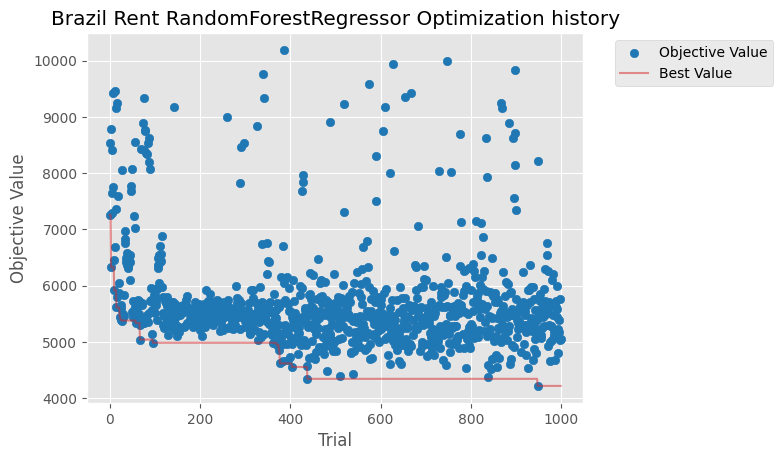

In [57]:
ax = plot_optimization_history(study)
ax.set_title("Brazil Rent RandomForestRegressor Optimization history")
ax

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_30580\2256747026.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_param_importances(study)


<Axes: title={'left': 'Brazil Rent RandomForestRegressor Hyperparameter Importance'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

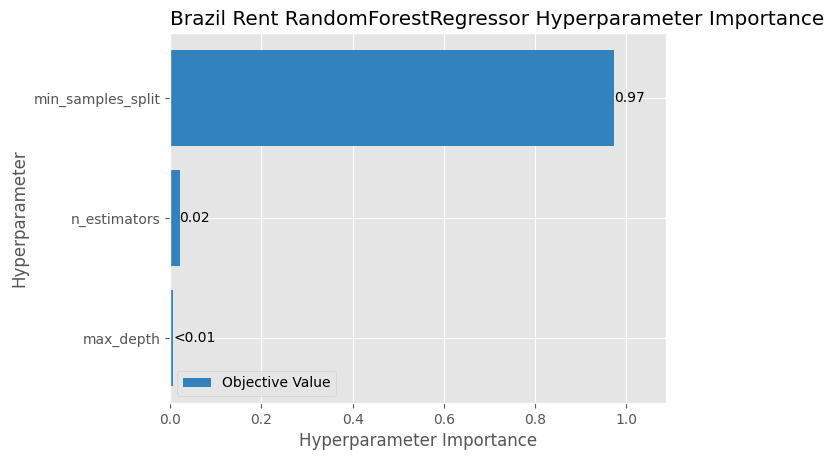

In [58]:
ax = plot_param_importances(study)
ax.set_title("Brazil Rent RandomForestRegressor Hyperparameter Importance", loc="left")
ax